# Notebook to make figures for conferences and manuscripts

Rainey Aberle

2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import contextily as cx
import geopandas as gpd
from skimage.measure import find_contours
import ee
import sys
from shapely.geometry import Point, LineString
import rasterio as rio
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import glob

# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

# determine whether to save output figures
save_figures = 1

# add path to functions
sys.path.insert(1, base_path+'functions/')
import ps_pipeline_utils as f

## Study sites

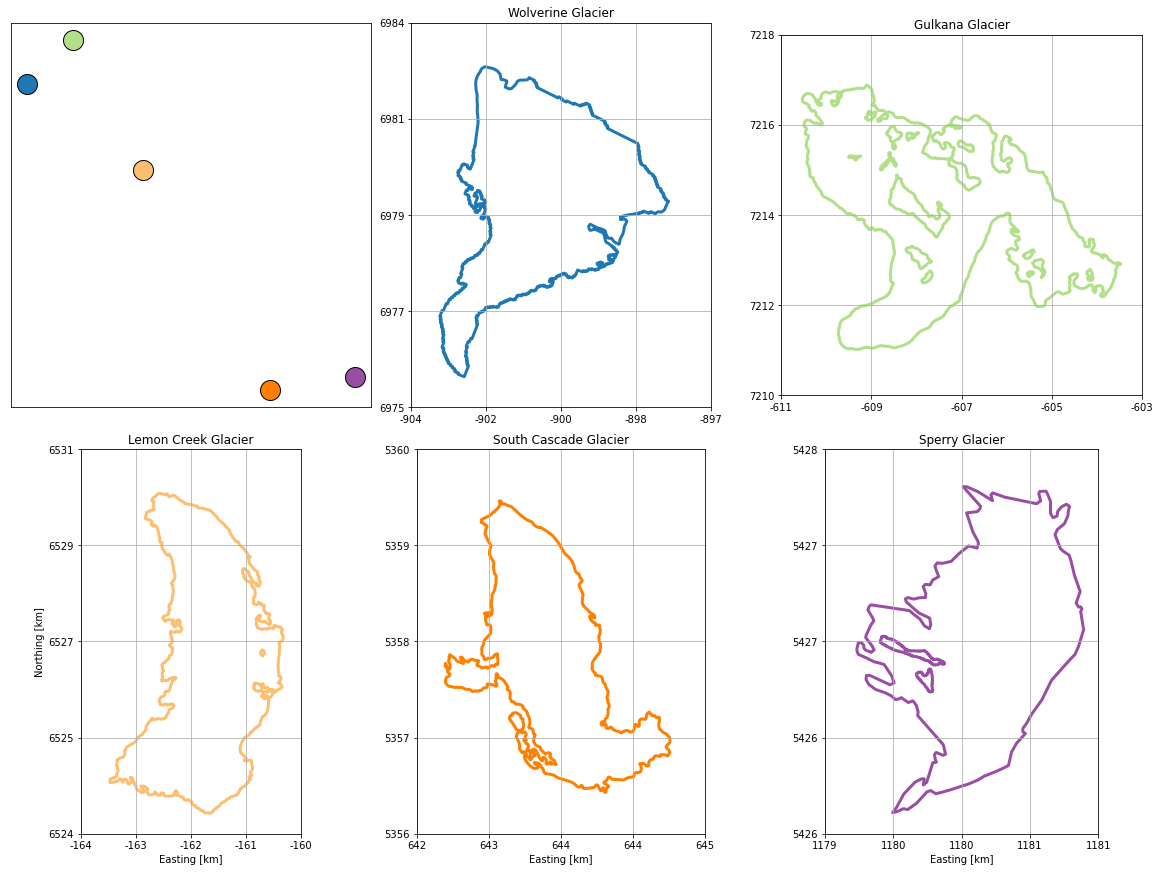

In [2]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SCascade', 'Sperry']
site_names_display = ['Wolverine', 'Gulkana', 'Lemon Creek', 'South Cascade', 'Sperry']
site_colors = ['#1f78b4', '#b2df8a', '#fdbf6f', '#ff7f00', '#984ea3']
text_labels = ['a', 'b', 'c', 'd', 'e', 'f']

# set up figure
fig, ax = plt.subplots(2, 3, figsize=(16, 12), layout="constrained")
ax = ax.flatten()
# ul - study sites map
epsg = 32610
ax[0].set_xticks([])
ax[0].set_yticks([])
# plot glacier outlines
for site_name, site_color, site_name_display, i in list(zip(site_names, site_colors, site_names_display, np.arange(0,len(site_names)))):
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    AOI = AOI.to_crs(epsg)
    # cx.add_basemap(ax=ax[0], crs=AOI.crs, source=cx.providers.Esri.WorldShadedRelief) 
    # cx.add_basemap(ax=ax[i+1], crs=AOI.crs, source=cx.providers.Esri.WorldShadedRelief) 
    ax[0].plot(AOI.geometry[0].centroid.xy[0][0], AOI.geometry[0].centroid.xy[1][0], 
            'o', markerfacecolor=site_color, markeredgecolor='k', markersize=20)
    AOI.plot(ax=ax[i+1], edgecolor=site_color, facecolor='none', linewidth=3)
    ax[i+1].grid()
    # change x and y tick labels to km
    xmin = np.min(ax[i+1].get_xticks())
    xmax = np.max(ax[i+1].get_xticks())
    ymin = np.min(ax[i+1].get_yticks())
    ymax = np.max(ax[i+1].get_yticks())
    ax[i+1].set_xticks(np.linspace(xmin, xmax, num=5))
    ax[i+1].set_xticklabels([str(int(x/1e3)) for x in ax[i+1].get_xticks()])
    ax[i+1].set_yticks(np.linspace(ymin, ymax, num=5))
    ax[i+1].set_yticklabels([str(int(y/1e3)) for y in ax[i+1].get_yticks()])
    ax[i+1].set_title(site_name_display + ' Glacier')
    # add axes labels
    if i==3:
        ax[i].set_ylabel('Northing [km]')
    if i > 1:
        ax[i+1].set_xlabel('Easting [km]')

    # 

# ax['mid'].set_xlabel('Easting [km]')
# ax['mid'].set_ylabel('Northing [m]')
# change x and y tick labels to km
# ax['mid'].set_xticks(np.linspace(-1250e3, 1250e3, num=6))
# ax['mid'].set_xticklabels([str(int(x/1e3)) for x in ax['mid'].get_xticks()])
# ax['mid'].set_yticks(np.linspace(5.3e6, 7.3e6, num=6))
# ax['mid'].set_yticklabels([str(int(y/1e3)) for y in ax['mid'].get_yticks()])
plt.show()

## Methods workflow

In [3]:
# Authenticate Google Earth Engine (GEE)
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

Downloading:   0%|          | 0.00/8.06k [00:00<?, ?iB/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_1351/4219261535.py:74: RuntimeWarning: invalid value encountered in true_divide
  H_snow_est_elev_norm = H_snow_est_elev / H_DEM


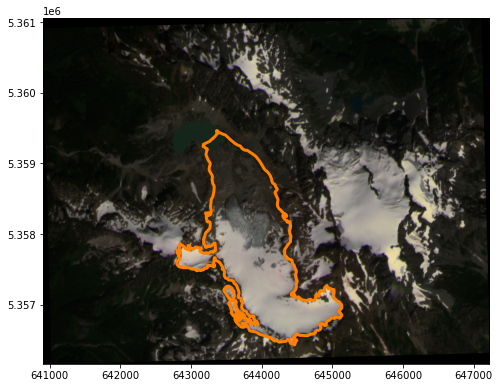

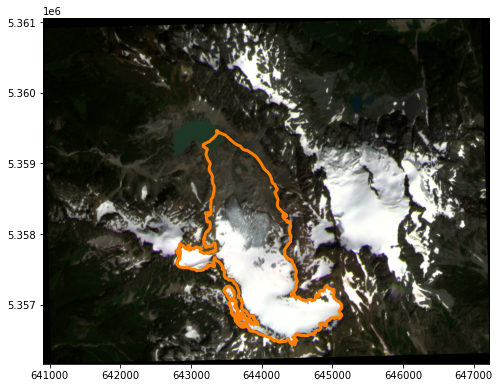

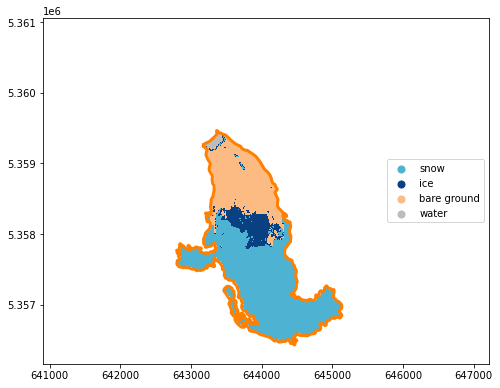

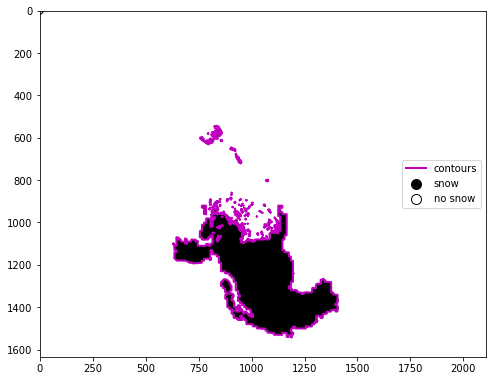

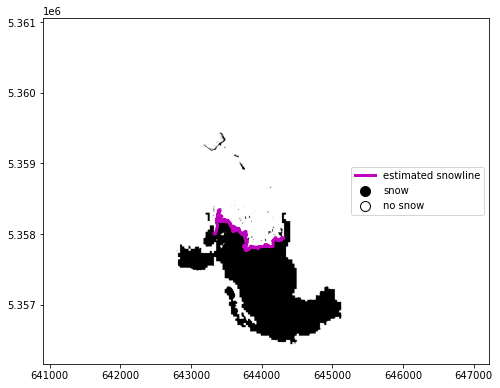

In [4]:
# -----Image settings
# image date
im_date = '20190728'
# image band scalar multiplier
im_scalar = 1e4
# site name
site_name = 'SCascade'
# RGI outline
AOI_fn = base_path + '../../GIS_data/RGI_outlines/SCascade_RGI.shp'
AOI = gpd.read_file(AOI_fn)
# query GEE for DEM
DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)
# define colors for classified image
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
# create colormap
colors = [color_snow, color_snow, color_ice, color_rock, color_water]
cmp = ListedColormap(colors)

# -----1. Raw image
im_path = base_path + '../study-sites/SCascade/imagery/PlanetScope/mosaics/'
im_fn = glob.glob(im_path + im_date + '*.tif')[0]
im = rxr.open_rasterio(im_fn)
im = im / im_scalar
xmin, xmax, ymin, ymax = np.min(im.x.data), np.max(im.x.data), np.min(im.y.data), np.max(im.y.data)
# plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.imshow(np.dstack([im.data[2], im.data[1], im.data[0]]), 
           extent=(xmin, xmax, ymin, ymax))
AOI_UTM.plot(ax=ax1, facecolor='none', edgecolor='#ff7f00', linewidth=3)

# -----2. Adjusted image
im_adj_path = base_path + '../study-sites/SCascade/imagery/PlanetScope/adjusted-filtered/'
im_adj_fn = glob.glob(im_adj_path+im_date+'*_adj.tif')[0]
im_adj = rxr.open_rasterio(im_adj_fn)
im_adj = im_adj / im_scalar
# plot
fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.imshow(np.dstack([im_adj.data[2], im_adj.data[1], im_adj.data[0]]), 
           extent=(xmin, xmax, ymin, ymax))
AOI_UTM.plot(ax=ax2, facecolor='none', edgecolor='#ff7f00', linewidth=3)

# -----3. Classified image
im_classified_path = base_path + '../study-sites/SCascade/imagery/PlanetScope/classified/'
im_classified_fn = glob.glob(im_classified_path+im_date+'*_classified.tif')[0]
im_classified = rxr.open_rasterio(im_classified_fn)
im_classified = im_classified.where(im_classified!=-9999) # remove no data values
# Adjust classified image
# mask the DEM using the AOI
mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                  out_shape=(len(DEM.y), len(DEM.x)),
                                  transform=DEM.transform,
                                  invert=True)
# convert mask to xarray DataArray
mask = xr.DataArray(mask , dims=("y", "x"))
# mask DEM values outside the AOI
DEM_AOI = DEM.where(mask == True)
# interpolate DEM to the image coordinates
band, x, y = im_classified.indexes.values() # grab indices of image
DEM_AOI_interp = DEM_AOI.interp(x=x, y=y, method="nearest") # interpolate DEM to image coordinates
# determine snow covered elevations
DEM_AOI_interp_snow = DEM_AOI_interp.where(im_classified<=2) # mask pixels not classified as snow
snow_est_elev = DEM_AOI_interp_snow.elevation.data.flatten() # create array of snow-covered pixel elevations
# determine bins to use in histograms
elev_min = np.fix(np.nanmin(DEM_AOI_interp.elevation.data.flatten())/10)*10
elev_max = np.round(np.nanmax(DEM_AOI_interp.elevation.data.flatten())/10)*10
bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max-elev_min)/10 + 1))
bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2
# calculate elevation histograms
H_DEM = np.histogram(DEM_AOI_interp.elevation.data.flatten(), bins=bin_edges)[0]
H_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
H_snow_est_elev_norm = H_snow_est_elev / H_DEM
# determine elevation with > 75% snow coverage
elev_75_snow = bin_centers[np.where(H_snow_est_elev_norm > 0.75)[0][0]]
# set all pixels above the elev_75_snow to snow (1)
im_classified_adj = xr.where(DEM_AOI_interp.elevation > elev_75_snow, 1, im_classified) # set all values above elev_75_snow to snow (1)
im_classified_adj = im_classified_adj.squeeze(drop=True) # drop unecessary dimensions
# define color scheme
# plot
fig3, ax3 = plt.subplots(figsize=(8,8))
ax3.imshow(im_classified_adj.data, cmap=cmp, vmin=1, vmax=5,
           extent=(xmin, xmax, ymin, ymax))
AOI_UTM.plot(ax=ax3, facecolor='none', edgecolor='#ff7f00', linewidth=3)
# plot dummy points for legend
ax3.scatter(0, 0, color=color_snow, s=50, label='snow')
ax3.scatter(0, 0, color=color_ice, s=50, label='ice')
ax3.scatter(0, 0, color=color_rock, s=50, label='bare ground')
ax3.scatter(0, 0, color=color_water, s=50, label='water')
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(ymin, ymax)
ax3.legend(loc='right')

# 4. Image contours
# create binary snow matrix
im_binary = xr.where(im_classified_adj <=2, 1, 0).data
# Find contours at a constant value of 0.5 (between 0 and 1)
contours = find_contours(im_binary, 0.5)
# convert contour points to image coordinates
contours_coords = []
for contour in contours: 
    ix = np.round(contour[:,1]).astype(int)
    iy = np.round(contour[:,0]).astype(int)
    coords = (im_adj.isel(x=ix, y=iy).x.data, # image x coordinates
              im_adj.isel(x=ix, y=iy).y.data) # image y coordinates
    # zip points together
    xy = list(zip([x for x in coords[0]], 
                  [y for y in coords[1]]))
    contours_coords = contours_coords + [xy]
# plot
fig4, ax4 = plt.subplots(figsize=(8,8))
binary_plt = ax4.imshow(im_binary, cmap='Greys')
for i, contour in list(zip(np.arange(0,len(contours)), contours)):
    if i==0:
        plt.plot(contour[:,1], contour[:,0], '-m', label='contours', linewidth=2)
    else:
        plt.plot(contour[:,1], contour[:,0], '-m', label='_nolegend', linewidth=2)
# plot dummy points for legend
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax4.set_xlim(0,len(im.x.data))
ax4.set_ylim(len(im.y.data), 0)
ax4.legend(loc='right')

# 5. Filtered contours / snow line
# extract snow lines (sl) from contours
sl_est = [] # initialize list of snow lines
# loop through contours
for c in contours_coords: 
    # create array of points
    c_points =  [Point(x,y) for x,y in c]
    # loop through points 
    line_points = [] # initialize list of points to use in snow line
    for point in c_points:
        # calculate distance from the point to the AOI boundary
        distance = AOI_UTM.boundary[0].distance(point)
        # only include points 200 m from the AOI boundary
        if distance >= 100:
            line_points = line_points + [point]
    if line_points: # if list of line points is not empty
        if len(line_points) > 1: # must have at least two points to create a LineString
            line = LineString([(p.xy[0][0], p.xy[1][0]) for p in line_points])
            sl_est = sl_est + [line]
# filter lines by length
sl_est_filt = []
for line in sl_est:
    if line.length > 1000:
        sl_est_filt = sl_est_filt + [line]  
# compile all line coordinates into arrays of x- and y-coordinates 
xpts, ypts = [], []
for line in sl_est_filt:
    xpts = xpts + [x for x in line.coords.xy[0]]
    ypts = ypts + [y for y in line.coords.xy[1]]  
xpts, ypts = np.array(xpts).flatten(), np.array(ypts).flatten()
# plot 
fig5, ax5 = plt.subplots(figsize=(8,8))
ax5.imshow(im_binary, cmap='Greys',
           extent=(xmin, xmax, ymin, ymax))
ax5.plot([x for x in xpts], 
         [y for y in ypts], 
         '-', color='m', label='estimated snowline', linewidth=3) 
# plot dummy points for legend
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin, ymax)
ax5.legend(loc='right')
plt.show()